## Counterfactual Regret Minimization

### by Lieqiang Guo & Yanting LI

This is the implementation of counterfactual regret minimization on game Kuhn Poker

In [1]:
import random
import numpy as np
from time import time
import matplotlib.pyplot as plt

In [2]:
class Node:
    '''Information set node class definition'''
    def __init__(self, node_id):
        '''Kuhn node definitions'''
        self.node_id = node_id
        self.n_actions = 2
        self.regret_sum = np.zeros(self.n_actions)
        self.strategy = np.zeros(self.n_actions)
        self.strategy_sum = np.zeros(self.n_actions)
        self.avg_strategy = np.zeros(self.n_actions)

    def getStrategy(self, realizationWeight):
        '''Get current information set mixed strategy through regret-matching'''
        self.strategy = np.copy(self.regret_sum)
        self.strategy[self.strategy < 0] = 0 # reset negative regrets to zero
        normalizing_sum = np.sum(self.strategy)
        if(normalizing_sum > 0):
            self.strategy /= normalizing_sum
        else:
            self.strategy = np.repeat(1 / self.n_actions, self.n_actions)
        self.strategy_sum += realizationWeight * self.strategy
        return self.strategy

    def getAverageStrategy(self):
        '''Get average information set mixed strategy across all training iteration'''
        normalizing_sum = np.sum(self.strategy_sum)
        if(normalizing_sum > 0):
            self.avg_strategy = self.strategy / normalizing_sum
        else:
            self.avg_strategy = np.repeat(1.0 / self.n_actions, self.n_actions)
        return self.avg_strategy

In [9]:
class KuhnTrainer:
    def __init__(self, max_iter=1000000):
        '''Contains Kuhn Poker definitions'''
        self.max_iter = max_iter
        self.n_actions = 2
        self.node_list = []
        self.node_dict = dict()
        
    def cfr(self, cards, action_history, p0, p1, avg_strategy=False):
        '''Counterfactual regret minimization iteration'''
        player = len(action_history)%2
        opponent = 1 - player
        
        # Return payoff for terminal states   - Algo. line 6-7
        nb_plays = len(action_history)
        if(nb_plays > 1):  # If history is terminal: For a terminal states, nb_plays equals to 2 or 3
            terminal_pass = action_history[nb_plays-1] == "p"
            double_bet = action_history[nb_plays-2:nb_plays] == "bb"
            is_player_card_higher = cards[player] > cards[opponent]
            
            if(terminal_pass):
                if(action_history == "pp"):
                    return 1 if is_player_card_higher else -1
                else:
                    return 1  
                    # there are 2 possibilities here:
                    # - pbp: current player is 3%2 = 1, so +1 to player 1
                    # - bp:  current player is 2%2 = 0, so +1 to player 0
            elif(double_bet):
                return 2 if is_player_card_higher else -2
        
        ## It is not a terminal(decision) node, then, it is a chance node:
        info_set = str(cards[player]) + action_history
        
        # Get information set node or create it if nonexistant
        if self.node_dict.get(info_set) == None:
            node_id = len(self.node_dict)
            self.node_dict[info_set] = node_id
            node = Node(node_id)
            self.node_list.append(node)
        else:
            node_id = self.node_dict.get(info_set)
            node = self.node_list[node_id]
        
        # For each action, recursively call cfr with additional history and reach_proba  - Algo. line 15-22
        if(avg_strategy):
            strategy = node.getAverageStrategy()
        else:
            strategy = node.getStrategy(p0 if player==0 else p1)
        
        util = np.zeros(self.n_actions)
        node_util = 0
        for a in range(self.n_actions):
            next_history = action_history + ("p" if a==0 else "b")
            if player == 0:
                util[a] = - self.cfr(cards, next_history, p0*strategy[a], p1)
            else:
                util[a] = - self.cfr(cards, next_history, p0, p1*strategy[a])
            node_util += strategy[a] * util[a]
        # For each action, compute and accumulate counterfactual regret  - Algo. line 23-29
        regret = util - node_util
        node.regret_sum += (p1 if player==0 else p0) * regret
        
        return node_util   
        
    def train(self, avg_strategy=False):
        '''Train Kuhn poker'''
        cards = [1,2,3]
        util = 0
        track_util = []
        for i in range(self.max_iter):
            # Shuffle cards
            for c1 in range(len(cards)-1, -1, -1):
                c2 = random.randint(0,c1)
                tmp = cards[c1]
                cards[c1] = cards[c2]
                cards[c2] = tmp
            v = self.cfr(cards, "", 1,1, avg_strategy)
            util += v
            track_util.append(util)
        print("Average game value: {}".format(util/self.max_iter))
        
        return track_util

In [13]:
trainer = KuhnTrainer(max_iter=10000)
track_util = trainer.train()

Average game value: -0.06027010959983617


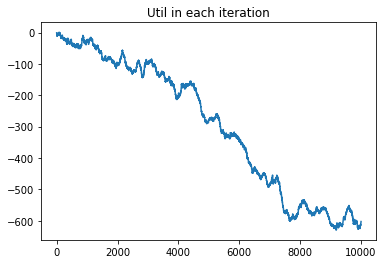

In [14]:
plt.figure()
plt.plot(track_util)
plt.title("Util in each iteration")
plt.show()

In [15]:
trainer = KuhnTrainer(max_iter = 10000)
track_util = trainer.train(avg_strategy=True)

Average game value: -0.20344486847477294


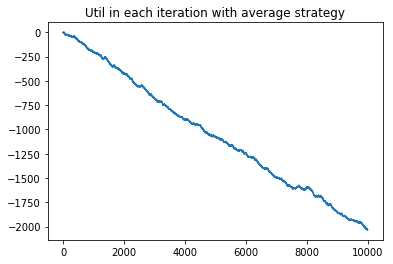

In [16]:
plt.figure()
plt.plot(track_util)
plt.title("Util in each iteration with average strategy")
plt.show()